In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import tensorflow_datasets as tfds

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

# from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

import pdb

In [2]:
with open('/kaggle/input/shak-new-input/train.txt', 'r', encoding='utf-8') as f:
    text_train = f.read()
    
with open('/kaggle/input/shak-new-input/test.txt', 'r', encoding='utf-8') as f:
    text_validation = f.read()    

In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text_train+text_validation)))
# chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
train_data = jnp.array(encode(text_train), dtype=jnp.int32)
test_data = jnp.array(encode(text_validation), dtype=jnp.int32)
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [6]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [7]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
seq_size = block_size//8

max_iters = 50000
learning_rate = 5e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 256
expans = 2
hidden_dim = n_embd*expans*4
conv_k_size = 3
n_latent_dim = 16
n_tokens = 1

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + n_tokens, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
(128, 64)
[[12  0  0 ... 53 42  1]
 [ 1 44 39 ... 56  1 45]
 [56 57  8 ... 10  0 17]
 ...
 [54 53 53 ... 17 17 26]
 [59 58 58 ... 16 21 33]
 [50  1 57 ... 47 58  1]]
targets:
(128, 64)
[[ 0  0 15 ... 42  1 40]
 [44 39 56 ...  1 45 56]
 [57  8  0 ...  0 17 47]
 ...
 [53 53 56 ... 17 26  1]
 [58 58 43 ... 21 33 31]
 [ 1 57 53 ... 58  1 40]]


In [8]:
class Mamba_Unet(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        embeds = nn.Embed(vocab_size, n_embd)(x) + nn.Embed(
            block_size, n_embd)(jnp.arange(block_size))
        
        conv1 = jax.nn.silu(nn.Conv(features=n_embd*expans, kernel_size=conv_k_size,padding=1)(embeds))
        
        max_pool1 = nn.max_pool(conv1 , window_shape=(2,), strides=(2,), padding='valid')
        max_pool1_ind = (conv1 == jnp.repeat(max_pool1 , repeats=2, axis=1)).astype(jnp.int32)
        
        conv2 = jax.nn.silu(nn.Conv(features=n_embd*expans*2, kernel_size=conv_k_size,padding=1)(max_pool1))
    
        max_pool2 = nn.max_pool(conv2 , window_shape=(2,), strides=(2,), padding='valid')
        max_pool2_ind = (conv2 == jnp.repeat(max_pool2 , repeats=2, axis=1)).astype(jnp.int32)   
        
        conv3 = jax.nn.silu(nn.Conv(features=n_embd*expans*4, kernel_size=conv_k_size,padding=1)(max_pool2))
    
        max_pool3 = nn.max_pool(conv3 , window_shape=(2,), strides=(2,), padding='valid')
        max_pool3_ind = (conv3 == jnp.repeat(max_pool3 , repeats=2, axis=1)).astype(jnp.int32)
        
        A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, hidden_dim, 1))
        B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, seq_size))
        C = 0.09*self.param('C', jax.random.normal, (1, n_latent_dim, 1, seq_size))
        D = 0.1*self.param('D', jax.random.normal, (1, 1,hidden_dim, seq_size))
        delta = 0.05*self.param('delta', jax.random.normal, (1, 1, hidden_dim, seq_size))
        
        x = nn.RMSNorm()(jnp.expand_dims(jnp.transpose(max_pool3,(0,2,1)), axis=1))
        x = self.ssm(x, A, B, C, D, delta)
        x = jnp.transpose(x[:,0,:,:],(0,2,1))
        ###############
        uconv3 = jnp.repeat(x, repeats=2, axis=1)*jnp.concatenate([max_pool3_ind[:,1:,:],jnp.ones((max_pool3_ind.shape[0],1,max_pool3_ind.shape[-1]))], axis=1)
        
        cat_conv3 = jnp.concatenate([conv3, uconv3], axis=-1)
        conv4 = jax.nn.silu(nn.Conv(features=cat_conv3.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv3))
        
        conv3T = nn.ConvTranspose(conv4.shape[-1]//2, kernel_size = 3, padding = 1)(conv4)
        ###############
        uconv2 = jnp.repeat(conv3T, repeats=2, axis=1)*jnp.concatenate([max_pool2_ind[:,1:,:],jnp.ones((max_pool2_ind.shape[0],1,max_pool2_ind.shape[-1]))], axis=1)
        
        cat_conv2 = jnp.concatenate([conv2, uconv2], axis=-1)
        conv5 = jax.nn.silu(nn.Conv(features=cat_conv2.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv2))
        
        conv2T = nn.ConvTranspose(conv5.shape[-1]//2, kernel_size = 3, padding = 1)(conv5)
        
        ###############
        uconv1 = jnp.repeat(conv2T, repeats=2, axis=1)*jnp.concatenate([max_pool1_ind[:,1:,:],jnp.ones((max_pool1_ind.shape[0],1,max_pool1_ind.shape[-1]))], axis=1)
        
        cat_conv1 = jnp.concatenate([conv1, uconv1], axis=-1)
        conv6 = jax.nn.silu(nn.Conv(features=cat_conv1.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv1))
        
        conv1T = nn.ConvTranspose(conv6.shape[-1]//2, kernel_size = 3, padding = 1)(conv6)
        ##############
#         pdb.set_trace()
        output = nn.Dense(vocab_size)(nn.RMSNorm()(conv1T))
        
                
#         first_uconv = jnp.repeat(max_pool1, repeats=2, axis=1)*max_pool1_ind
        
        
        return output
    
    def discretize(self, A, B, delta):
        da = delta * A
        a_ = jnp.exp(da)
        b_ = B * delta
        return a_, b_

    def ssm(self, x, A, B, C, D, delta):
        a_, b_ = self.discretize(A, B, delta)
        h = 0
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
#         _, N, D, S = a_.shape
#         indices = jnp.tril(jnp.ones((S-1,S-1))) 
#         indices = jnp.expand_dims(a_[...,1:],axis=4)*jnp.expand_dims(indices, axis=(0,1,2)) + jnp.expand_dims(jnp.triu(jnp.ones((S-1,S-1)),1), axis=(0,1,2))
#         indices = (jnp.concatenate((indices, jnp.ones((1,N,D,S-1,1))), axis=-1)).prod(axis=-2)
#         h = (indices*(b_*x)).sum(axis=-1)

        y = ((C * jax.lax.expand_dims(h,[3])).sum(1, keepdims=True) + D*x)
        
#         self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return y    
                

In [9]:
def loss_fun(params, x, y, dropout_key):
    logits = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [10]:
key = jax.random.PRNGKey(42)
# x = jnp.expand_dims(xb[0],axis=0)
x = xb
model = Mamba_Unet()

params = model.init(jax.random.PRNGKey(45),x)
print(params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total number of parameters: {n_params:_}")

output = model.apply(params, x)
print(output.shape)

dict_keys(['params'])
Total number of parameters: 49_669_961
(128, 64, 65)


In [11]:
opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [12]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, subkey)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, train_accuracy

# for i in tqdm(range(max_iters)):
counter = 0
loss = 10
while counter<max_iters: # and loss > 1.0:

    params, key, opt_state, loss, train_accuracy = step(key, params, opt_state)
    

    # once every N_FREQ_EVAL we compute loss on the validation set
    if counter % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data))
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('##########################################################')
        print("Step: ", counter,"\t Train Loss: ", loss,"\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", counter,"\t Eval Loss: ", eval_loss,"\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
    counter += 1
        

2024-06-28 09:07:31.672403: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,2048,32]{2,1,0}, u8[0]{0}) custom-call(f32[128,1024,32]{2,1,0}, f32[1024,2048,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-06-28 09:07:32.020330: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.348057411s
Trying algorithm eng0{} for conv (f32[128,2048,32]{2,1,0}, u8[0]{0}) custom-call(f32[128,1024,32]{2,1,0}, f32[1024,2048,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config

##########################################################
Step:  0 	 Train Loss:  4.6463537 	 Train Accuracy:  1.78%
Step:  0 	 Eval Loss:  2.465721 	 Eval Accuracy:  40.80%
##########################################################
Step:  100 	 Train Loss:  0.04393089 	 Train Accuracy:  98.86%
Step:  100 	 Eval Loss:  0.03904993 	 Eval Accuracy:  99.05%
##########################################################
Step:  200 	 Train Loss:  0.037410073 	 Train Accuracy:  99.00%
Step:  200 	 Eval Loss:  0.038721446 	 Eval Accuracy:  98.94%
##########################################################
Step:  300 	 Train Loss:  0.037078798 	 Train Accuracy:  98.97%
Step:  300 	 Eval Loss:  0.039507095 	 Eval Accuracy:  98.90%
##########################################################
Step:  400 	 Train Loss:  0.03759235 	 Train Accuracy:  98.91%
Step:  400 	 Eval Loss:  0.040213272 	 Eval Accuracy:  98.88%
##########################################################
Step:  500 	 Train Loss:  0.0

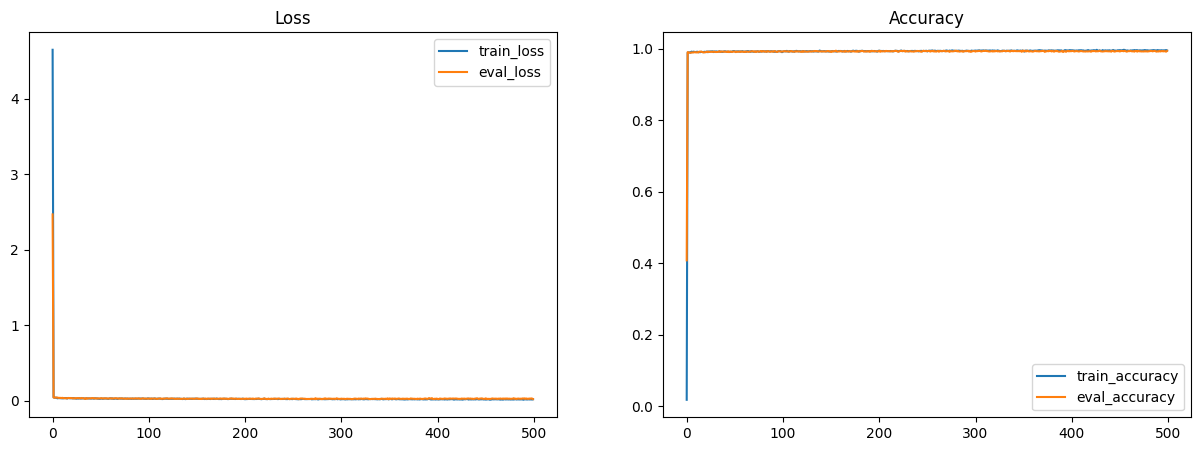

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [14]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = model.apply(params, context)
#         pdb.set_trace()
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -n_tokens, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        print(context.shape)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.expand_dims(test_data[852:852+block_size], axis=0)),
    (),
    length=length,
    )
    return new_tokens

In [15]:
test_data[852:852+block_size]

Array([51,  6,  1, 53, 56,  1, 43, 50, 57, 43,  1, 63, 53, 59,  1, 42, 53,
        1, 51, 43,  1, 61, 56, 53, 52, 45, 10,  0, 20, 47, 57,  1, 52, 39,
       51, 43,  1, 47, 57,  1, 24, 47, 41, 47, 53,  6,  1, 40, 53, 56, 52,
        1, 47, 52,  1, 25, 39, 52, 58, 59, 39,  8,  0,  0], dtype=int32)

In [16]:
i = 852
decode(test_data[i:i+block_size].tolist())

'm, or else you do me wrong:\nHis name is Licio, born in Mantua.\n\n'

In [17]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print('\n')
print(decode(token_gen))

(1, 64)
[24, 13, 16, 37, 1, 31, 24, 17, 33, 18, 26, 21, 13, 52, 1, 15, 27, 18, 44, 53, 56, 42, 8, 0, 0, 19, 30, 17, 25, 21, 27, 10, 0, 14, 46, 39, 58, 2, 1, 61, 56, 43, 52, 49, 1, 57, 39, 63, 57, 1, 58, 46, 43, 56, 43, 12, 1, 58, 46, 43, 1, 53, 50, 42, 1, 41, 56, 53, 61, 52, 1, 42, 39, 63, 57, 8, 0, 27, 1, 14, 53, 50, 47, 52, 45, 40, 56, 53, 49, 43, 6, 1, 57, 47, 52, 41, 43, 1, 50, 47, 49, 43, 1, 53, 40, 43, 63, 57, 1, 40, 43, 45, 39, 52, 6, 0, 33, 50, 50, 54, 39, 56, 42, 57, 1, 53, 44, 1, 54, 43, 56, 43, 57, 57, 43, 52, 53, 53, 59, 57, 6, 1, 58, 46, 56, 39, 52, 63, 1, 47, 52, 45, 56, 47, 51, 39, 45, 43, 6, 0, 13, 52, 42, 1, 58, 46, 53, 57, 43, 1, 58, 46, 53, 59, 1, 46, 39, 57, 58, 1, 56, 47, 45, 46, 58, 1, 47, 52, 1, 40, 43, 39, 59, 58, 63, 10, 1, 53, 59, 56, 1, 55, 59, 43, 43, 52, 8, 0, 0, 26, 53, 30, 32, 20, 33, 25, 14, 17, 30, 24, 13, 26, 16, 10, 0, 26, 53, 1, 61, 53, 56, 42, 6, 1, 53, 52, 1, 39, 50, 50, 1, 58, 46, 43, 1, 17, 52, 45, 50, 39, 52, 42, 1, 41, 46, 53, 47, 57, 43, 42, 6